In [1]:
! pip install glove-python-binary

In [2]:
import os

import pandas as pd
import numpy as np
import json

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from glove import Corpus, Glove
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import accuracy_score
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
train_data = pd.read_csv('C:/Users/DSSAL/Downloads/XGB_mobilehealth/revision_data/traindata_2020_afterCovid.csv')

In [34]:
train_data = train_data.dropna()

In [35]:
reviews = list(train_data['clean_review'])
sentiments = list(train_data['sentiment'])

In [36]:
token = []
for review in reviews:
    token.append(review.split())

In [37]:
#Glove Corpus 생성
corpus = Corpus()
corpus.fit(token, window=20)

In [38]:
# model
glove = Glove(no_components=128, learning_rate=0.01, random_state=82)     
%time glove.fit(corpus.matrix, epochs=50, no_threads=4, verbose=False)    
glove.add_dictionary(corpus.dictionary)

# save
glove.save('C:/Users/DSSAL/Downloads/XGB_mobilehealth' + '/glove_w20_epoch50.model')

Wall time: 11 s


In [39]:
# load glove
glove_model = Glove.load('C:/Users/DSSAL/Downloads/XGB_mobilehealth' + '/glove_w20_epoch50.model')

# word dict 생성
word_dict = {}
for word in  glove_model.dictionary.keys():
    word_dict[word] = glove_model.word_vectors[glove_model.dictionary[word]]
print('[Success !] Lengh of word dict... : ', len(word_dict))

[Success !] Lengh of word dict... :  7219


In [40]:
# save word_dict
import pickle
with open('C:/Users/DSSAL/Downloads/XGB_mobilehealth'+ '/glove_word_dict_128.pickle', 'wb') as f:
    pickle.dump(word_dict, f)
print('[Success !] Save word dict!...')

[Success !] Save word dict!...


In [41]:
#검증데이터셋 성능 평가
test_data = pd.read_csv('C:/Users/DSSAL/Downloads/XGB_mobilehealth/revision_data/testdata_2021_afterCovid.csv')
test_data = test_data.dropna()

test_reviews = list(test_data['clean_review'])

In [42]:
test_tokens = []
for review in test_reviews:
    test_tokens.append(review.split())

In [43]:
# test data 워드 임베딩 // ...?왜한걸까..?
# word dict : train데이터의 임베딩 사전
total_word_dict = {}
cnt = 0

for word in test_tokens:
    for i in range(len(word)):
        if word[i] in word_dict.keys():
            total_word_dict[word[i]] = word_dict[word[i]]
        else:
            word_dict[word[i]] = np.zeros((128))
            cnt += 1  # 처음 본 단어 갯수 세기

print('no train word -> 0....', cnt)
print('token -> word embedding....!',len(total_word_dict))

no train word -> 0.... 2906
token -> word embedding....! 4338


In [44]:
# embedding
def sent2vec_glove(tokens, embedding_dim=128):
    '''문장 token 리스트를 받아서 임베딩 시킨다.'''
  
    size = len(tokens)
    matrix = np.zeros((size, embedding_dim))
    word_table = word_dict     # glove word_dict

    for i, token in enumerate(tokens):
        vector = np.array([
            word_table[t] for t in token
            if t in word_table
        ])

        if vector.size != 0:
            final_vector = np.mean(vector, axis=0)
            matrix[i] = final_vector

    return matrix

In [45]:
# 문장 임베딩
sentence_glove = sent2vec_glove(reviews)
sentence_glove.shape

(19462, 128)

In [46]:
from sklearn.model_selection import train_test_split
import numpy as np

x_train = sentence_glove
y_train = np.array(sentiments)

In [49]:
# 하이퍼 파라미터 튜닝 및 XGboost 훈련
from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier(random_state=82, n_estimators = 100, learning_rate=0.2, max_depth=4)

xgb_param_grid = {
    'n_estimators' : [200, 600, 1000], #200, 400, 600
    'learning_rate' : [0.05, 0.1, 0.2], #, 0.05, 0.1, 0.15, 0.2
    'max_depth' : [4, 6, 8] #4, 6, 8, 12
}

xgb = GridSearchCV(xgb, param_grid = xgb_param_grid, scoring = 'accuracy', n_jobs=-1, verbose=3, cv=5)
#n_jobs = XGBoost를 실행하는데 사용되는 병렬 스레드 수

# 단어 묶음을 벡터화한 데이터와 정답 데이터를 가지고 학습을 시작한다.
bst = xgb.fit(x_train, y_train, verbose=3)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


C:\Users\DSSAL\Anaconda3\lib\site-packages\cupy\_environment.py:214: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  'CUDA path could not be detected.'
C:\Users\DSSAL\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:14:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [50]:
print("Accuracy: %f" %  xgb.score(x_train, y_train))

Accuracy: 0.902990


In [51]:
sentence_glove = sent2vec_glove(test_reviews)

test_input = sentence_glove

In [52]:
realAnswer = list(test_data['sentiment'])
test_label = np.array(realAnswer)

In [53]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = xgb.predict(test_input)
predictions = [round(value) for value in y_pred]

accuracy_score(test_label, predictions)

C:\Users\DSSAL\Anaconda3\lib\site-packages\cupy\_environment.py:214: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  'CUDA path could not be detected.'


0.7656439485811303

Text(0.5, 257.44, 'Predicted label')

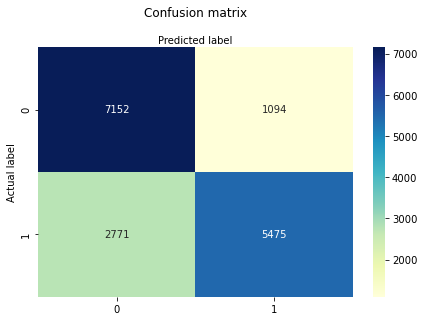

In [54]:
cnf_matrix = metrics.confusion_matrix(test_label, predictions)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [55]:
print("Accuracy:",metrics.accuracy_score(test_label, predictions))
print("Precision:",metrics.precision_score(test_label, predictions))
print("Recall:",metrics.recall_score(test_label, predictions))

Accuracy: 0.7656439485811303
Precision: 0.8334601918100167
Recall: 0.6639582828037837


In [74]:
import joblib

# 모델 저장
joblib.dump(xgb, 'C:/Users/DSSAL/Downloads/XGB_mobilehealth/xgb_glove_with_gridsearch_afterCovid.pkl')

# 모델 불러오기
xgb_model = joblib.load('C:/Users/DSSAL/Downloads/XGB_mobilehealth/xgb_glove_with_gridsearch_afterCovid.pkl')

In [75]:
xgb_model

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.2, max_delta_step=None,
                                     max_depth=4, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=82, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,

In [76]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = xgb_model.predict(test_input)
predictions = [value for value in y_pred]

accuracy_score(test_label, predictions)

C:\Users\DSSAL\Anaconda3\lib\site-packages\cupy\_environment.py:214: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  'CUDA path could not be detected.'


0.7656439485811303

In [77]:
from sklearn.metrics import classification_report

report = classification_report(test_label, y_pred, target_names=['class low', 'class high'], output_dict=True)
df = pd.DataFrame(report).transpose()

df

,precision,recall,f1-score,support
class low,0.720750,0.867330,0.787275,8246.000000
class high,0.833460,0.663958,0.739116,8246.000000
accuracy,0.765644,0.765644,0.765644,0.765644
macro avg,0.777105,0.765644,0.763195,16492.000000
weighted avg,0.777105,0.765644,0.763195,16492.000000


In [78]:
xgb.best_params_

{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}